# Dataset Balancing

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

from helper_func.preprocess_func import preprocess_data

## Data Exploration

In [ ]:
SCENARIO_ONE_INSIDE_CSV = "../../../data/DARPA/Scenario_One/inside/inside_labeled_flows_all.csv"
data_out_root_dir = "../processed_data_notebooks/scenario_one/inside/stratified/sampled"

In [4]:
df = pd.read_csv(SCENARIO_ONE_INSIDE_CSV)
df.head()

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,attack_id,attack,phase
0,f0,9.524389e+08,9.524389e+08,0.101800,172.16.112.50,33354,172.16.114.50,80,tcp,http,...,ShADadfF,8,614,9,8261,-,6,0,0,0
1,f1,9.524389e+08,9.524389e+08,0.001107,172.16.114.50,45135,172.16.115.20,53,udp,dns,...,Dd,1,72,1,159,-,17,0,0,0
2,f2,9.524389e+08,9.524389e+08,0.064488,172.16.113.204,22641,172.16.112.100,25,tcp,smtp,...,ShAdtDFaf,12,1107,22,1382,-,6,0,0,0
3,f3,9.524389e+08,9.524389e+08,0.001167,172.16.112.100,1061,172.16.115.20,53,udp,dns,...,Dd,2,146,1,159,-,17,0,0,0
4,f4,9.524389e+08,9.524389e+08,0.000861,172.16.113.204,1438,172.16.115.20,53,udp,dns,...,Dd,1,73,1,159,-,17,0,0,0


In [5]:
def check_class_distribution(y, phases=[1,2,3,4,5], plot=False):
    '''
    This function checks the class distribution of the given labels y.
    '''
    y_filtered = [label for label in y if label in phases] 
    counts = Counter(y_filtered)
    num_samples_per_phase = dict(counts)
    
    total_num_samples = sum(counts.values())
    print(f"Total number of samples: {total_num_samples}")

    for phase in phases:
        count = counts.get(phase, 0)
        percentage = (count / total_num_samples) * 100
        print(f"Phase {phase}: {count} samples ({percentage:.2f}%)")
    
    if plot:
        plt.bar(num_samples_per_phase.keys(), num_samples_per_phase.values())
        plt.xlabel('Phase')
        plt.ylabel('Number of Flows')
        plt.title('Number of Flows per Phase in Scenario One Inside Dataset')
        plt.show()

    return num_samples_per_phase


In [6]:
df_phases = df["phase"]

Total number of samples: 125825
Phase 0: 91972 samples (73.10%)
Phase 1: 20 samples (0.02%)
Phase 2: 22 samples (0.02%)
Phase 3: 35 samples (0.03%)
Phase 4: 22 samples (0.02%)
Phase 5: 33754 samples (26.83%)


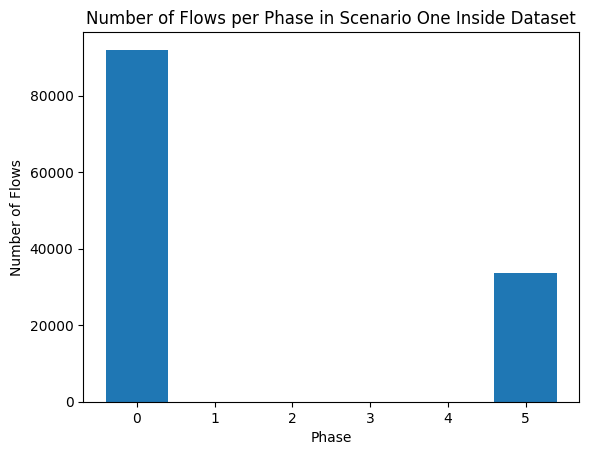

In [7]:
num_samples_per_phase_full = check_class_distribution(df_phases, phases=[0,1,2,3,4,5], plot=True)

Total number of samples: 33853
Phase 1: 20 samples (0.06%)
Phase 2: 22 samples (0.06%)
Phase 3: 35 samples (0.10%)
Phase 4: 22 samples (0.06%)
Phase 5: 33754 samples (99.71%)


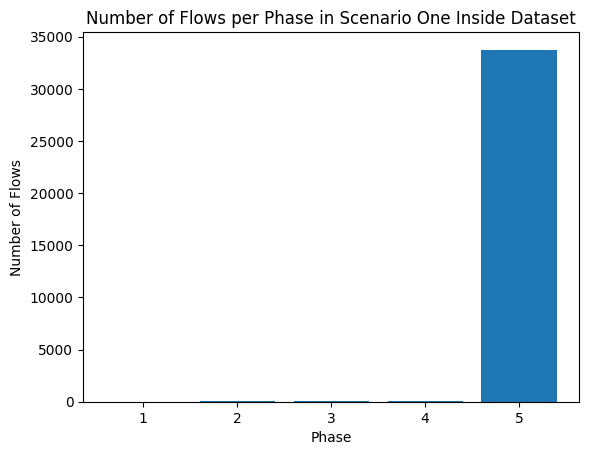

In [8]:
num_samples_per_phase_attack = check_class_distribution(df_phases, phases=[1,2,3,4,5], plot=True)

Total number of samples: 99
Phase 1: 20 samples (20.20%)
Phase 2: 22 samples (22.22%)
Phase 3: 35 samples (35.35%)
Phase 4: 22 samples (22.22%)


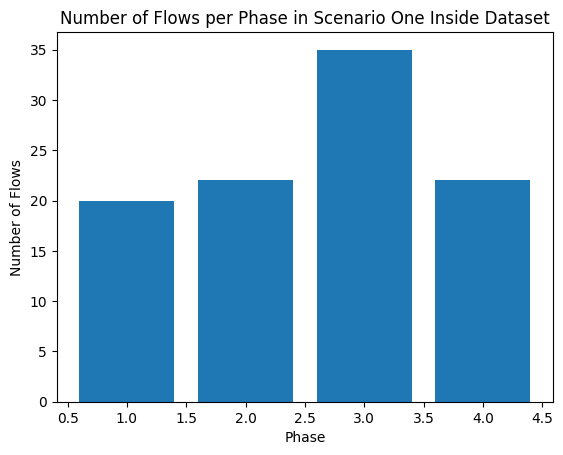

In [9]:
num_samples_per_phase_subsample = check_class_distribution(df_phases, phases=[1,2,3,4], plot=True)

## Load the datasets

In [10]:
# Config

SEED = 123

FEATURE_LIST_FILE_NAME = f"../features_list.json"
with open(FEATURE_LIST_FILE_NAME) as f:
    feature_list = json.load(f)
print(feature_list)

ip_encoding = "none"

['duration', 'proto', 'service', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'ip_proto']


In [11]:
# Split data into train/test (stratified)
train_size = 0.6
test_size = 1 - train_size

# Stratified split based on "phase" column
df_train, df_test = train_test_split(
    df, test_size=test_size, stratify=df_phases, random_state=SEED 
)

print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

df_train.head()

Train set shape: (75495, 26)
Test set shape: (50330, 26)


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,attack_id,attack,phase
30301,f30301,9.524437e+08,9.524437e+08,0.000797,172.16.113.84,1967,172.16.115.20,53,udp,dns,...,Dd,1,63,1,123,-,17,0,0,0
121252,f121252,9.524491e+08,9.524491e+08,0.113402,172.16.116.44,21397,135.145.64.75,80,tcp,http,...,ShADadfF,13,710,24,30459,-,6,0,0,0
103980,f103980,9.524465e+08,9.524465e+08,0.000000,16.246.210.128,36958,131.84.1.31,23669,tcp,-,...,A,1,40,0,0,-,6,31607,1,5
112109,f112109,9.524465e+08,9.524465e+08,0.000000,122.157.40.45,34920,131.84.1.31,31198,tcp,-,...,A,1,40,0,0,-,6,0,0,0
83648,f83648,9.524465e+08,9.524465e+08,0.000000,121.128.53.167,26893,131.84.1.31,6277,tcp,-,...,A,1,40,0,0,-,6,21582,1,5


In [12]:
print("\nClass distribution in Train set:")
df_train_phases = df_train["phase"]
num_samples_per_phase_train = check_class_distribution(df_train_phases, phases=[1,2,3,4,5])


Class distribution in Train set:
Total number of samples: 20312
Phase 1: 12 samples (0.06%)
Phase 2: 13 samples (0.06%)
Phase 3: 21 samples (0.10%)
Phase 4: 13 samples (0.06%)
Phase 5: 20253 samples (99.71%)


## Random Sampling 

In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [14]:
def sample_classes_random(mode, X, y, desired_target, attack_phases=[1,2,3,4,5]):
    '''
    This function performs random upsampling or downsampling of 
    the attack phases in y to reach the desired target count.
    '''
    counts = Counter(y)
    print('Before sampling:', Counter(counts))

    if mode == 'upsample':
        # Create sampling strategy 
        sampling_strategy = {p: desired_target for p in attack_phases if counts.get(p, 0) < desired_target}
        print('Sampling strategy (per-phase target):', sampling_strategy)
        # Perform random oversampling
        ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=SEED)
        X_resampled, y_resampled = ros.fit_resample(X, y)
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    elif mode == 'downsample': 
        # Create sampling strategy 
        sampling_strategy = {p: desired_target for p in attack_phases if counts.get(p, 0) > desired_target}
        print('Sampling strategy (per-phase target):', sampling_strategy)
        # Perform random undersampling
        rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=SEED)
        X_resampled, y_resampled = rus.fit_resample(X, y)
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    else:
        raise ValueError("Mode should be either 'upsample' or 'downsample'.")

    print('After sampling:', Counter(y_resampled))

    return X_resampled, y_resampled

### Oversampling

In [15]:
mode = 'upsample'

counts = Counter(df_train_phases)
phase = 5
desired_target = counts[phase]
print(f'Desired target): {desired_target}\n')

df_train_upsampled, _ = sample_classes_random(
    mode='upsample', 
    X=df_train, 
    y=df_train_phases, 
    desired_target=desired_target
)

df_train_upsampled.head()

Desired target): 20253

Before sampling: Counter({0: 55183, 5: 20253, 3: 21, 2: 13, 4: 13, 1: 12})
Sampling strategy (per-phase target): {1: 20253, 2: 20253, 3: 20253, 4: 20253}
After sampling: Counter({0: 55183, 5: 20253, 3: 20253, 2: 20253, 4: 20253, 1: 20253})


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,attack_id,attack,phase
0,f30301,9.524437e+08,9.524437e+08,0.000797,172.16.113.84,1967,172.16.115.20,53,udp,dns,...,Dd,1,63,1,123,-,17,0,0,0
1,f121252,9.524491e+08,9.524491e+08,0.113402,172.16.116.44,21397,135.145.64.75,80,tcp,http,...,ShADadfF,13,710,24,30459,-,6,0,0,0
2,f103980,9.524465e+08,9.524465e+08,0.000000,16.246.210.128,36958,131.84.1.31,23669,tcp,-,...,A,1,40,0,0,-,6,31607,1,5
3,f112109,9.524465e+08,9.524465e+08,0.000000,122.157.40.45,34920,131.84.1.31,31198,tcp,-,...,A,1,40,0,0,-,6,0,0,0
4,f83648,9.524465e+08,9.524465e+08,0.000000,121.128.53.167,26893,131.84.1.31,6277,tcp,-,...,A,1,40,0,0,-,6,21582,1,5


Total number of samples: 156448
Phase 0: 55183 samples (35.27%)
Phase 1: 20253 samples (12.95%)
Phase 2: 20253 samples (12.95%)
Phase 3: 20253 samples (12.95%)
Phase 4: 20253 samples (12.95%)
Phase 5: 20253 samples (12.95%)


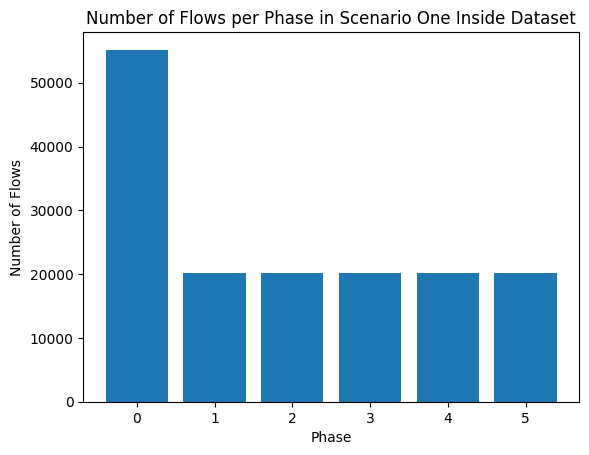

In [16]:
_ = check_class_distribution(df_train_upsampled["phase"], phases=[0,1,2,3,4,5], plot=True)

Total number of samples: 156448
Phase 0: 55183 samples (35.27%)
Phase 1: 101265 samples (64.73%)


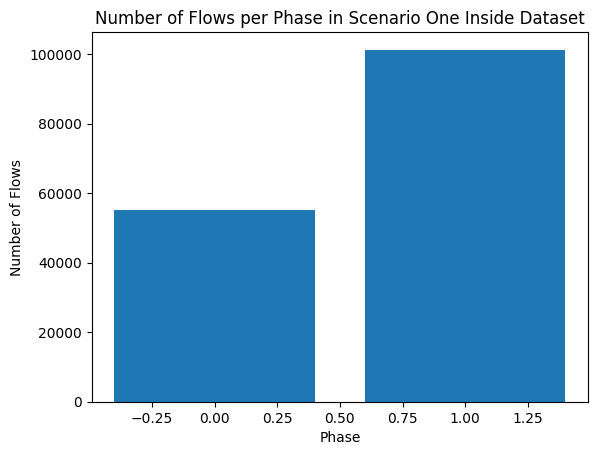

In [17]:
_ = check_class_distribution(df_train_upsampled["attack"], phases=[0,1], plot=True)

In [18]:
preprocess_data(
    df_train_upsampled, df_test, feature_list, ip_encoding,
    output_dir=f"{data_out_root_dir}/upsampled"
)

Saved X, y, y_phase, and preprocessing pipeline to ../processed_data_notebooks/scenario_one/inside/stratified/sampled/upsampled/


### Downsampling

Likely not the best option as the dataset is not very large to begin with.

In [19]:
mode = 'downsample'

counts = Counter(df_train_phases)
# phase = 3
# desired_target = counts[phase]
desired_target = 30 # manually chosen
print(f'Desired target: {desired_target}\n')

df_train_downsampled, _ = sample_classes_random(
    mode='downsample', 
    X=df_train, 
    y=df_train_phases,
    desired_target=desired_target
)

df_train_downsampled.head()

Desired target: 30

Before sampling: Counter({0: 55183, 5: 20253, 3: 21, 2: 13, 4: 13, 1: 12})
Sampling strategy (per-phase target): {5: 30}
After sampling: Counter({0: 55183, 5: 30, 3: 21, 2: 13, 4: 13, 1: 12})


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,attack_id,attack,phase
30301,f30301,9.524437e+08,9.524437e+08,0.000797,172.16.113.84,1967,172.16.115.20,53,udp,dns,...,Dd,1,63,1,123,-,17,0,0,0
121252,f121252,9.524491e+08,9.524491e+08,0.113402,172.16.116.44,21397,135.145.64.75,80,tcp,http,...,ShADadfF,13,710,24,30459,-,6,0,0,0
112109,f112109,9.524465e+08,9.524465e+08,0.000000,122.157.40.45,34920,131.84.1.31,31198,tcp,-,...,A,1,40,0,0,-,6,0,0,0
82578,f82578,9.524465e+08,9.524465e+08,0.000000,66.25.85.195,22119,131.84.1.31,4540,tcp,-,...,A,1,40,0,0,-,6,0,0,0
33496,f33496,9.524445e+08,9.524445e+08,0.000799,172.16.117.132,1430,172.16.115.20,53,udp,dns,...,Dd,1,63,1,123,-,17,0,0,0


Total number of samples: 55195
Phase 0: 55183 samples (99.98%)
Phase 1: 12 samples (0.02%)


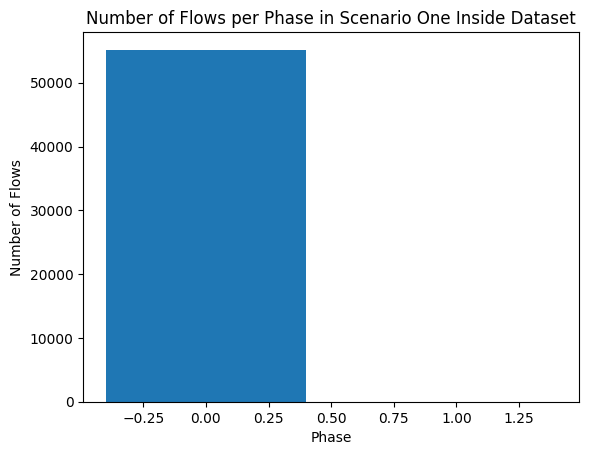

In [20]:
_ = check_class_distribution(df_train_downsampled["phase"], phases=[0,1], plot=True)

Total number of samples: 55272
Phase 0: 55183 samples (99.84%)
Phase 1: 89 samples (0.16%)


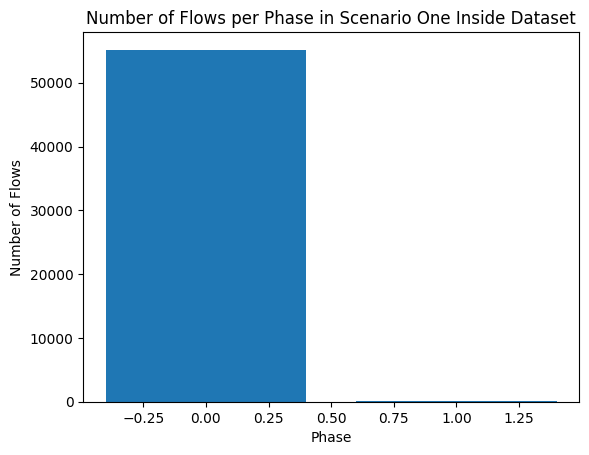

In [21]:
_ = check_class_distribution(df_train_downsampled["attack"], phases=[0,1], plot=True)

In [22]:
preprocess_data(
    df_train_downsampled, df_test, feature_list, ip_encoding,
    output_dir=f"{data_out_root_dir}/downsampled"
)

Saved X, y, y_phase, and preprocessing pipeline to ../processed_data_notebooks/scenario_one/inside/stratified/sampled/downsampled/


### Sample Test Set

In [23]:
print("\nClass distribution in Test set:")
df_test_phases = df_test["phase"]
num_samples_per_phase_test = check_class_distribution(df_test_phases, phases=[1,2,3,4,5])


Class distribution in Test set:
Total number of samples: 13541
Phase 1: 8 samples (0.06%)
Phase 2: 9 samples (0.07%)
Phase 3: 14 samples (0.10%)
Phase 4: 9 samples (0.07%)
Phase 5: 13501 samples (99.70%)


In [24]:
counts = Counter(df_test_phases)
print('Before downsampling:', Counter(counts))
desired_target = 30 # manually chosen
print(f'Desired target: {desired_target}\n')

df_test_downsampled, _ = sample_classes_random(
    mode='downsample', 
    X=df_test, 
    y=df_test_phases,
    desired_target=desired_target
)

df_test_downsampled.head()

Before downsampling: Counter({0: 36789, 5: 13501, 3: 14, 4: 9, 2: 9, 1: 8})
Desired target: 30

Before sampling: Counter({0: 36789, 5: 13501, 3: 14, 4: 9, 2: 9, 1: 8})
Sampling strategy (per-phase target): {5: 30}
After sampling: Counter({0: 36789, 5: 30, 3: 14, 2: 9, 4: 9, 1: 8})


,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,attack_id,attack,phase
86579,f86579,9.524465e+08,9.524465e+08,0.000000,112.217.58.213,23806,131.84.1.31,26359,tcp,-,...,A,1,40,0,0,-,6,0,0,0
54174,f54174,9.524465e+08,9.524465e+08,0.000000,104.200.249.22,10493,131.84.1.31,18688,tcp,-,...,A,1,40,0,0,-,6,0,0,0
108482,f108482,9.524465e+08,9.524465e+08,0.000000,91.172.52.33,32623,131.84.1.31,17380,tcp,-,...,A,1,40,0,0,-,6,0,0,0
11649,f11649,9.524395e+08,9.524395e+08,0.001043,172.16.112.100,3283,172.16.115.20,53,udp,dns,...,Dd,2,212,1,159,-,17,0,0,0
22471,f22471,9.524410e+08,9.524410e+08,0.000650,172.16.115.1,52402,172.16.115.20,53,udp,dns,...,Dd,1,73,1,158,-,17,0,0,0


In [25]:
# Upsample train & downsample test
preprocess_data(
    df_train_upsampled, df_test_downsampled, feature_list, ip_encoding,
    output_dir=f"{data_out_root_dir}/updown"
)

Saved X, y, y_phase, and preprocessing pipeline to ../processed_data_notebooks/scenario_one/inside/stratified/sampled/updown/


In [26]:
# Downsample train & test
preprocess_data(
    df_train_downsampled, df_test_downsampled, feature_list, ip_encoding,
    output_dir=f"{data_out_root_dir}/downdown"
)

Saved X, y, y_phase, and preprocessing pipeline to ../processed_data_notebooks/scenario_one/inside/stratified/sampled/downdown/


### SMOTE (Synthetic Minority Oversampling Technique)

In [27]:
# TODO